# Setup

In [276]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
torch.cuda.empty_cache()
import numpy as np
import evaluate

In [3]:
!nvidia-smi

Sun Apr  9 17:43:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:8A:00.0 Off |                    0 |
| N/A   62C    P0   260W / 300W |  22282MiB / 32480MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Load model

For the function name techdebt scorer,  we are training Microsoft's codebert-base RoBERTa-based model with SequenceClassification head.

It would be logical to formulate the training task as NSP, but RoBERTa-based models do not train on NSP task, have a different sep token __\</s>__ and do not have token_type_ids. Manuals say that you can just __omit all TTID logic__ and feed it different logical parts of the input (func name and arguments with body in this case), split by tokenizer.sep_token.

We will be testing this hypothesis.

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base')
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")

## Load data

In [183]:
giga_df = pd.read_parquet("pyfunc_272k.parquet").reset_index(drop=True)

In [184]:
len(giga_df)

2331149

In [185]:
giga_df

,functionName,functionArgs,functionCode
0,__init__,"[self, allow, disallow, secure]","\n\ndef __init__(self, allow=None, disallow=No..."
1,__init__,"[self, field]","\n\ndef __init__(self, field):\n self.field..."
2,__get__,"[self, instance, owner]","\n\ndef __get__(self, instance, owner):\n i..."
3,__set__,"[self, instance, value]","\n\ndef __set__(self, instance, value):\n i..."
4,__delete__,"[self, instance]","\n\ndef __delete__(self, instance):\n del i..."
...,...,...,...
2331144,find_ana_sq,"[tass, squares]","\n\ndef find_ana_sq(tass, squares):\n all_s..."
2331145,main,[],\n\n@timed\ndef main():\n words = get_words...
2331146,__init__,"[self, name, path, drive_type, site_id]","\n\ndef __init__(self, name=None, path=None, d..."
2331147,from_docker_envvars,[config],\n\ndef from_docker_envvars(config):\n if (...


## Process data
To keep things simple and representative, we will  remove functions like \_\_init\_\_ and \_\_getitem\_\_, ones that contain decorators, and ones that exceed 512 tokens, truncating them

In [ ]:
filt_df = giga_df[giga_df['functionCode'].str.startswith("\n\ndef ")]
filt_df = filt_df[~filt_df['functionName'].str.startswith("__")].reset_index(drop=True)

sample_df = filt_df.head(100000)
sample_df['functionCode'] = [s[s.find('('):] for s in sample_df['functionCode']]
sample_df.head(5)

Now, we chose 50% of the functions and shuffle names with random ones in the dataset, checking that they do not end up being the same.

In [ ]:
true_df = sample_df[:50000]
true_df['label'] = np.full(len(true_df), 0)
#0 - correct

false_df = sample_df[50000:].reset_index(drop=True)

function_names = false_df["functionName"].to_list()
function_names_new = np.random.permutation(filt_df["functionName"].to_list())[:50000]

has_intersections = True

while has_intersections:
    intersections = [i for i in range(len(function_names)) if function_names[i] == function_names_new[i]]
    int_len = len(intersections)
    if int_len == 0:
        has_intersections = False
    else:
        print("more shuffling")
        function_names_new[intersections] = np.random.permutation(filt_df["functionName"].to_list())[:int_len]

false_df["functionName"] = function_names_new
false_df['label'] = np.full(len(false_df), 1)
#1 - incorrect

In [215]:
full_df = pd.concat([true_df, false_df]).reset_index(drop=True)
len(full_df)

100000

RoBERTa-based models - which CodeBERT is - do not train on NSP task, have a different sep token \</s> and do not have token_type_ids.
Manuals say that you can just __omit all TTID logic__ and feed it different logical parts of the input (func name and arguments with body
in this case), split by tokenizer.sep_token.

So let's try it out!

In [ ]:
full_df['tokenizedStr'] = [tokenizer(n + tokenizer.sep_token + c, max_length = 512, truncation = True, padding = True, return_tensors ='pt') for n,c in tqdm(full_df[['functionName', 'functionCode']].values)]

In [228]:
full_df['tokenizedStrLen'] = [len(x['input_ids'][0]) for x in full_df['tokenizedStr']]
full_df

,functionName,functionArgs,functionCode,label,tokenizedStr,tokenizedStrLen
0,get_attname,[self],(self):\n return ('%s_json' % self.name)\n,0,"[input_ids, attention_mask]",27
1,contribute_to_class,"[self, cls, name]","(self, cls, name):\n super(JSONField, self)...",0,"[input_ids, attention_mask]",89
2,fix_init_kwarg,"[self, sender, args, kwargs]","(self, sender, args, kwargs, **signal_kwargs):...",0,"[input_ids, attention_mask]",112
3,formfield,[self],"(self, *args, **kwargs):\n kwargs['form_cla...",0,"[input_ids, attention_mask]",53
4,get_internal_type,[self],(self):\n return 'TextField'\n,0,"[input_ids, attention_mask]",21
...,...,...,...,...,...,...
99995,test_chef_retrieval,[self],(self):\n wireless = None\n wired = None...,1,"[input_ids, attention_mask]",230
99996,test_grad_penalty_gan,[self],(self):\n return self._storedWiFiNetworks\n,1,"[input_ids, attention_mask]",28
99997,as_rgb,"[self, networkId]","(self, networkId):\n for i in range(0, len(...",1,"[input_ids, attention_mask]",243
99998,init_converter,[self],(self):\n return True\n,1,"[input_ids, attention_mask]",18


In [235]:
untrunc_df = full_df[full_df['tokenizedStrLen'] < 512]

80/20 train/test split will be used

In [236]:
train, test = train_test_split(untrunc_df, test_size=0.2)

In [239]:
print(f"train len: {len(train)}, test len: {len(test)}")

train len: 72129, test len: 18033


# SС training

In [250]:
inputs_train = tokenizer([n + tokenizer.sep_token + c for n,c in train[['functionName', 'functionCode']].values],
                         return_tensors='pt', max_length=512,
                         truncation=True, padding='max_length')

100%|██████████| 72129/72129 [00:00<00:00, 242325.44it/s]


In [253]:
inputs_train['labels'] = torch.LongTensor([train['label'].to_list()]).T

In [252]:
inputs_test = tokenizer([n + tokenizer.sep_token + c for n,c in test[['functionName', 'functionCode']].values],
                         return_tensors='pt', max_length=512,
                         truncation=True, padding='max_length')

In [254]:
inputs_test['labels'] = torch.LongTensor([test['label'].to_list()]).T

In [255]:
class FunctionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [263]:
dataset_train = FunctionsDataset(inputs_train)
dataset_test = FunctionsDataset(inputs_test)

loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# and move our model over to the selected device
model.to(device)

## TFTrainer training method

In [282]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(output_dir="checkpoingnts",
                                  logging_dir = "logging",
                                  logging_strategy="steps",
                                  logging_steps=400,
                                  evaluation_strategy="epoch",
                                  num_train_epochs=5,
                                  optim="adamw_torch",
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  learning_rate = 5e-5,
                                 )

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [283]:
# Start training
trainer.train()

***** Running training *****
  Num examples = 72129
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 22545
  Number of trainable parameters = 124647170
/tmp/ipykernel_21112/2919874237.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1
1,0.210100,0.211535,0.942434
2,0.126800,0.200887,0.947658
3,0.095400,0.206500,0.953583
4,0.043100,0.209041,0.959032
5,0.023800,0.229176,0.960475


Saving model checkpoint to checkpoingnts/checkpoint-500
Configuration saved in checkpoingnts/checkpoint-500/config.json
Model weights saved in checkpoingnts/checkpoint-500/pytorch_model.bin
/tmp/ipykernel_21112/2919874237.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Saving model checkpoint to checkpoingnts/checkpoint-1000
Configuration saved in checkpoingnts/checkpoint-1000/config.json
Model weights saved in checkpoingnts/checkpoint-1000/pytorch_model.bin
/tmp/ipykernel_21112/2919874237.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.it

TrainOutput(global_step=22545, training_loss=0.10241379192172093, metrics={'train_runtime': 12824.3415, 'train_samples_per_second': 28.122, 'train_steps_per_second': 1.758, 'total_flos': 9.48896865603072e+16, 'train_loss': 0.10241379192172093, 'epoch': 5.0})

In [291]:
train_history = [obj for obj in trainer.state.log_history if 'loss' in obj.keys()]
eval_history = [obj for obj in trainer.state.log_history if 'eval_loss' in obj.keys()]

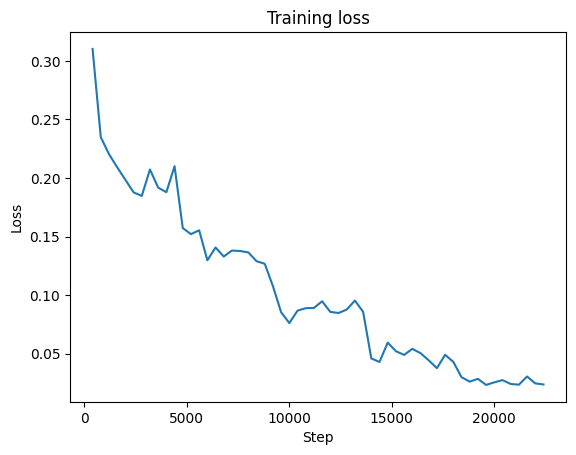

In [310]:
import matplotlib.pyplot as plt

x = [obj['step'] for obj in train_history]
y = [obj['loss'] for obj in train_history]

plt.title('Training loss')
plt.plot(x,y)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

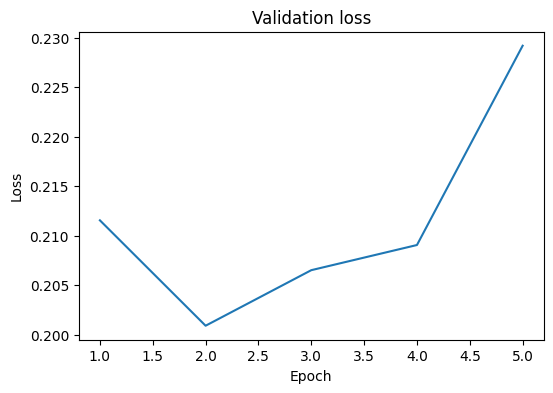

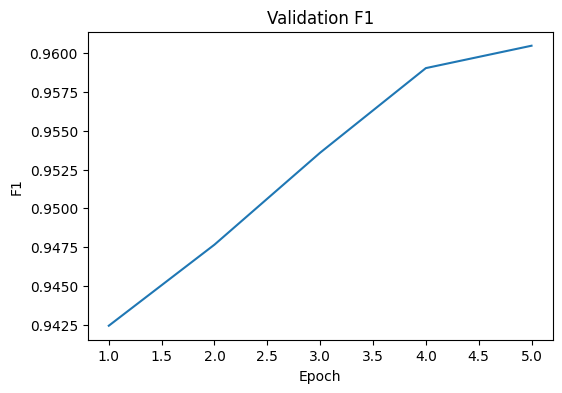

In [318]:
import matplotlib.pyplot as plt

x = [obj['epoch'] for obj in eval_history]
y_loss = [obj['eval_loss'] for obj in eval_history]
y_f1 = [obj['eval_f1'] for obj in eval_history]


plt.figure(figsize=(6,4))
plt.plot(x,y_loss)
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(6,4))
plt.plot(x,y_f1)
plt.title('Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.show()

Epoch 4 (around 18k steps) seems like the best candidate, as after that model seems to overfit

## [Legacy] - PyTorch training method

In [261]:
from torch.optim import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-6)

In [ ]:
epochs = 5

for epoch in range(epochs):
    loop = tqdm(loader, leave=True)
    for batch in loop:
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        
        loss = outputs.loss
        loss.backward()
        optim.step()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    
    